In [1]:
%matplotlib inline
import netCDF4
import rasterio
import os
from datetime import datetime
import numpy as np
import spotpy
import matplotlib.pyplot as plt
from os.path import join

In [2]:
# local libraries
from coupling_PCR_FM.model_functions_v2 import PCR_model, CMF_model, DFM_model
from coupling_PCR_FM.utils import config_to_dict, determineSteps
%config Application.log_level="INFO"

In [3]:
# IMPORT MODEL SETTINGS FROM INI-FILE
argv1 = r'couplingSettings.set'
argv2 = r'modelPaths.env'

# parse set/ini-file with central/general settings for coupling framework
config = config_to_dict(argv1)
# parse env-file for user-specific paths and environmental variables
envs = config_to_dict(argv2)
# combine
config.update(envs)
options = config
# parse dates
start_date = datetime.strptime(options['numerical_settings']['startTime'], '%Y-%m-%d')
end_date = datetime.strptime(options['numerical_settings']['endTime'], '%Y-%m-%d')
print start_date
print end_date
timeSteps = determineSteps(start_date, end_date)
print timeSteps

2000-01-01 00:00:00
2001-12-31 00:00:00
730


In [4]:
# setup output dir
cwd = os.getcwd() # note: this get changed by pcr initialization later on
out_dir = options['PCRpaths']['outputDirectoryPCR']
out_dir = out_dir + 'PCR2CMF/'
if not os.path.isdir(out_dir):
    os.mkdir(out_dir)
print(out_dir)
print(cwd)

/home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2CMF/
/home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim


## create PCR model BMI object

Note that we use a two step initializiation. in the first step the bmi object is initialized and the model config file is read into memory. This config file can then be changed offline before the model is initialized. This allows for change model input files and setting based on the model coupling.

In [5]:
PCR_configfile = os.path.join(cwd, options['hydrologic_model']['config_dir'], options['hydrologic_model']['config_file'])
PCR_in_dir = options['PCRpaths']['inputDirectoryPCR']
PCR_out_dir = os.path.join(out_dir, 'PCR')

PCR_bmi = PCR_model(PCR_configfile, PCR_in_dir, PCR_out_dir,
                            start_date, end_date)


The illustrate the two-step initialization, the model config file is shown

In [6]:
PCR_bmi.model_config

OrderedDict([(u'globalOptions',
              OrderedDict([('inputDir',
                            u'/home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim/test_Elbe/PCR_Elbe/input30min'),
                           ('cloneMap', u'clone_elbe_30min.map'),
                           ('landmask', u'landmask_elbe_30min.map'),
                           ('outputDir',
                            u'/home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2CMF/PCR'),
                           ('institution',
                            u'Department of Physical Geography, Utrecht University'),
                           ('title', u'PCR-GLOBWB output'),
                           ('description',
                            u'test version by Edwin H. Sutanudjaja; adapted by J. Hoch'),
                           ('startTime', '2000-01-01'),
                           ('endTime', '2001-12-31'),
                           ('maxSpinUpsInYears', u'1'),
                           ('minConvForTotlSto', u'0.5'),
  

## create CMF model BMi object

In [7]:
CMF_engine = os.path.join(cwd, options['CMF_engine']['CMF_path'])
CMF_model_dir = os.path.join(cwd, options['routing_model']['model_dir'])
CMF_config_fn = os.path.join(CMF_model_dir, options['routing_model']['model_file'])
CMF_out_dir = os.path.join(out_dir, 'CMF')
     
CMF_bmi = CMF_model(CMF_engine, CMF_config_fn, CMF_model_dir, CMF_out_dir,
                         start_date, end_date)

## couple grids based on CMF inpmat file

In [8]:
# couple
PCR_bmi.couple_grid_to_grid(CMF_bmi)

## initialize models

In [9]:
# initialize model at CMF_out_dir after inpmat has been set in the grid_to_grid coupling function.
CMF_bmi.initialize()
# initialize model 
PCR_bmi.initialize()

INFO: configuration.initialize_logging(): Model run started at 2018-03-22 19:38:11.666110
2018-03-22 19:38:11,671 pcrglobwb_bmi_v203.configuration INFO Model run started at 2018-03-22 19:38:11.666110
INFO: configuration.initialize_logging(): Logging output to /home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2CMF/PCR/log/setup_PCR_30min_Elbe.ini_2018-03-22T19:38:11.666110.log
2018-03-22 19:38:11,673 pcrglobwb_bmi_v203.configuration INFO Logging output to /home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2CMF/PCR/log/setup_PCR_30min_Elbe.ini_2018-03-22T19:38:11.666110.log
INFO: configuration.repair_ini_key_names(): Note that avgSurfaceWaterInputLongIni is not used and not needed.
2018-03-22 19:38:11,674 pcrglobwb_bmi_v203.configuration INFO Note that avgSurfaceWaterInputLongIni is not used and not needed.
INFO: configuration.repair_ini_key_names(): The initial condition "subDischargeIni" is not defined. Either "avgDischargeShortIni" or "avgDischargeLongIni" is used in this run. No

## run coupled PCR - CMF model

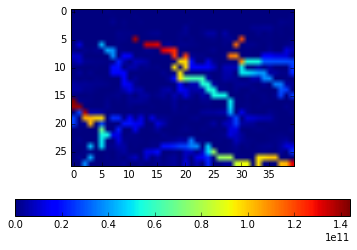

In [10]:
#- get upsteram area at comparison point in CMF
#upArea = np.fromfile(r'/home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim/test_Elbe/CMF_Elbe/uparea.bin', 'f').reshape(28,40)
upArea = np.fromfile(join(cwd, r'test_Elbe/CMF_Elbe/uparea.bin'), 'f').reshape(28,40)
plt.imshow(upArea)
plt.colorbar(orientation='horizontal')

In [11]:
#- check whether upstream area at chosen location is at the upper end
#- upstream area according to GRDC: 131950 km2 = 1.31950e11 m2
xCMFout = 6
yCMFout = 13
print (upArea[xCMFout, yCMFout])

1.34112e+11


In [12]:
# create file for writing CMF output
cmf_outFile = os.path.join(CMF_out_dir, 'qsim_CFM_at_location_' + str(xCMFout) + '_' + str(yCMFout) + '.txt')
cmf_of = open(cmf_outFile, 'w')
print (cmf_of)

<open file u'/home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2CMF/CMF/qsim_CFM_at_location_6_13.txt', mode 'w' at 0x7f7b0b63b540>


In [13]:
# run coupled model for 20 timesteps
def update_states():
    "coupling runoff between CMFan PCR model"
#     runoff = PCR_bmi.get_var('landSurfaceRunoff')
    runoff = PCR_bmi.get_var('runoff')
    runoff = np.where(np.isnan(runoff), 0, runoff)
    CMF_bmi.set_var("roffin", runoff)
        
tStart = datetime.now()
for i in range(timeSteps):
# for i in range(10):
    PCR_bmi.update()
    update_states()
    CMF_bmi.update()  
    outflw_temp = np.copy(CMF_bmi.get_var('outflw'))[xCMFout, yCMFout]
    cmf_of.write(str(outflw_temp) + os.linesep)
tEnd = datetime.now()
cmf_of.close()

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-01
2018-03-22 19:38:24,827 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-01
INFO: pcrglobwb.update(): updating model to time 2000-01-01
2018-03-22 19:38:25,101 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-01, timestep 1
2018-03-22 19:38:27,240 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-01, timestep 1
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-02 00:00:00, timestep 86400.0
2018-03-22 19:38:27,464 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-02 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-02
2018-03-22 19:38:27,470 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-02
INFO

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-11
2018-03-22 19:38:42,052 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-11
INFO: pcrglobwb.update(): updating model to time 2000-01-11
2018-03-22 19:38:42,406 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-11, timestep 11
2018-03-22 19:38:43,506 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-11, timestep 11
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-12 00:00:00, timestep 86400.0
2018-03-22 19:38:43,635 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-12 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-12
2018-03-22 19:38:43,641 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-12
IN

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-21
2018-03-22 19:38:58,055 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-21
INFO: pcrglobwb.update(): updating model to time 2000-01-21
2018-03-22 19:38:58,419 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-21, timestep 21
2018-03-22 19:38:59,556 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-21, timestep 21
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-22 00:00:00, timestep 86400.0
2018-03-22 19:38:59,625 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-22 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-22
2018-03-22 19:38:59,628 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-22
IN

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-31
2018-03-22 19:39:14,197 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-31
INFO: pcrglobwb.update(): updating model to time 2000-01-31
2018-03-22 19:39:14,648 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-31
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-31, timestep 31
2018-03-22 19:39:15,774 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-31, timestep 31
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-02-01 00:00:00, timestep 86400.0
2018-03-22 19:39:15,981 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-02-01 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-01
2018-03-22 19:39:15,985 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-01
IN

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-10
2018-03-22 19:39:31,437 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-10
INFO: pcrglobwb.update(): updating model to time 2000-02-10
2018-03-22 19:39:31,834 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-10, timestep 41
2018-03-22 19:39:32,963 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-10, timestep 41
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-02-11 00:00:00, timestep 86400.0
2018-03-22 19:39:33,026 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-02-11 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-11
2018-03-22 19:39:33,030 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-11
IN

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-20
2018-03-22 19:39:47,517 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-20
INFO: pcrglobwb.update(): updating model to time 2000-02-20
2018-03-22 19:39:47,933 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-20, timestep 51
2018-03-22 19:39:49,064 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-20, timestep 51
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-02-21 00:00:00, timestep 86400.0
2018-03-22 19:39:49,084 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-02-21 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-21
2018-03-22 19:39:49,085 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-21
IN

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-01
2018-03-22 19:40:03,869 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-01
INFO: pcrglobwb.update(): updating model to time 2000-03-01
2018-03-22 19:40:04,330 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-01, timestep 61
2018-03-22 19:40:05,718 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-01, timestep 61
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-03-02 00:00:00, timestep 86400.0
2018-03-22 19:40:05,779 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-03-02 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-02
2018-03-22 19:40:05,784 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-02
IN

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-11
2018-03-22 19:40:19,975 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-11
INFO: pcrglobwb.update(): updating model to time 2000-03-11
2018-03-22 19:40:20,358 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-11, timestep 71
2018-03-22 19:40:21,492 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-11, timestep 71
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-03-12 00:00:00, timestep 86400.0
2018-03-22 19:40:21,534 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-03-12 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-12
2018-03-22 19:40:21,540 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-12
IN

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-21
2018-03-22 19:40:36,330 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-21
INFO: pcrglobwb.update(): updating model to time 2000-03-21
2018-03-22 19:40:36,722 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-21, timestep 81
2018-03-22 19:40:37,861 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-21, timestep 81
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-03-22 00:00:00, timestep 86400.0
2018-03-22 19:40:37,921 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-03-22 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-22
2018-03-22 19:40:37,927 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-22
IN

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-31
2018-03-22 19:40:52,942 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-31
INFO: pcrglobwb.update(): updating model to time 2000-03-31
2018-03-22 19:40:53,311 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-31
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-31, timestep 91
2018-03-22 19:40:54,487 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-31, timestep 91
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-01 00:00:00, timestep 86400.0
2018-03-22 19:40:54,574 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-01 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-01
2018-03-22 19:40:54,579 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-01
IN

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-10
2018-03-22 19:41:09,730 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-10
INFO: pcrglobwb.update(): updating model to time 2000-04-10
2018-03-22 19:41:10,138 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-10, timestep 101
2018-03-22 19:41:11,286 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-10, timestep 101
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-11 00:00:00, timestep 86400.0
2018-03-22 19:41:11,420 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-11 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-11
2018-03-22 19:41:11,422 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-11


2018-03-22 19:41:26,232 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-20 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-20
2018-03-22 19:41:26,238 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-20
INFO: pcrglobwb.update(): updating model to time 2000-04-20
2018-03-22 19:41:26,618 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-20, timestep 111
2018-03-22 19:41:27,782 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-20, timestep 111
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-21 00:00:00, timestep 86400.0
2018-03-22 19:41:27,908 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-21 00:00:00, timestep 86400.0
INFO: pcrg

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-30 00:00:00, timestep 86400.0
2018-03-22 19:41:42,691 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-30 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-30
2018-03-22 19:41:42,693 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-30
INFO: pcrglobwb.update(): updating model to time 2000-04-30
2018-03-22 19:41:43,070 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-30, timestep 121
2018-03-22 19:41:44,243 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-30, timestep 121
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-01 00:00:00, timestep 86400.0
2018-03-22 19:41:44,259 coupling_PCR_FM

2018-03-22 19:41:58,754 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-09, timestep 130
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-10 00:00:00, timestep 86400.0
2018-03-22 19:41:59,017 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-10 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-10
2018-03-22 19:41:59,019 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-10
INFO: pcrglobwb.update(): updating model to time 2000-05-10
2018-03-22 19:41:59,465 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-10, timestep 131
2018-03-22 19:42:00,602 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-10, timestep 131
INFO: model_functions_v2.update(

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-19, timestep 140
2018-03-22 19:42:15,332 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-19, timestep 140
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-20 00:00:00, timestep 86400.0
2018-03-22 19:42:15,365 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-20 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-20
2018-03-22 19:42:15,368 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-20
INFO: pcrglobwb.update(): updating model to time 2000-05-20
2018-03-22 19:42:15,736 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-20, timestep 141
2018-03-22 19:42:16,868 coupling_PCR_FM.model_functions_v2 IN

INFO: pcrglobwb.update(): updating model to time 2000-05-29
2018-03-22 19:42:30,588 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-29, timestep 150
2018-03-22 19:42:31,736 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-29, timestep 150
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-30 00:00:00, timestep 86400.0
2018-03-22 19:42:31,805 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-30 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-30
2018-03-22 19:42:31,811 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-30
INFO: pcrglobwb.update(): updating model to time 2000-05-30
2018-03-22 19:42:32,206 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-30
INFO: model_f

2018-03-22 19:42:46,925 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-08
INFO: pcrglobwb.update(): updating model to time 2000-06-08
2018-03-22 19:42:47,287 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-08, timestep 160
2018-03-22 19:42:48,418 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-08, timestep 160
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-06-09 00:00:00, timestep 86400.0
2018-03-22 19:42:48,492 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-06-09 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-09
2018-03-22 19:42:48,498 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-09
INFO: pcrglobwb.update(): updating model to time 2000-06-09
2018-03-22

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-18
2018-03-22 19:43:03,429 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-18
INFO: pcrglobwb.update(): updating model to time 2000-06-18
2018-03-22 19:43:03,832 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-18, timestep 170
2018-03-22 19:43:04,982 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-18, timestep 170
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-06-19 00:00:00, timestep 86400.0
2018-03-22 19:43:05,149 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-06-19 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-19
2018-03-22 19:43:05,155 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-19


2018-03-22 19:43:20,028 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-06-28 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-28
2018-03-22 19:43:20,033 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-28
INFO: pcrglobwb.update(): updating model to time 2000-06-28
2018-03-22 19:43:20,385 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-28, timestep 180
2018-03-22 19:43:21,496 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-28, timestep 180
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-06-29 00:00:00, timestep 86400.0
2018-03-22 19:43:21,610 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-06-29 00:00:00, timestep 86400.0
INFO: pcrg

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-08 00:00:00, timestep 86400.0
2018-03-22 19:43:36,582 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-08 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-08
2018-03-22 19:43:36,584 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-08
INFO: pcrglobwb.update(): updating model to time 2000-07-08
2018-03-22 19:43:36,972 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-08, timestep 190
2018-03-22 19:43:38,096 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-08, timestep 190
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-09 00:00:00, timestep 86400.0
2018-03-22 19:43:38,211 coupling_PCR_FM

2018-03-22 19:43:53,236 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-17, timestep 199
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-18 00:00:00, timestep 86400.0
2018-03-22 19:43:53,298 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-18 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-18
2018-03-22 19:43:53,301 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-18
INFO: pcrglobwb.update(): updating model to time 2000-07-18
2018-03-22 19:43:53,659 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-18, timestep 200
2018-03-22 19:43:54,833 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-18, timestep 200
INFO: model_functions_v2.update(

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-27, timestep 209
2018-03-22 19:44:09,507 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-27, timestep 209
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-28 00:00:00, timestep 86400.0
2018-03-22 19:44:09,603 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-28 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-28
2018-03-22 19:44:09,608 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-28
INFO: pcrglobwb.update(): updating model to time 2000-07-28
2018-03-22 19:44:10,069 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-28, timestep 210
2018-03-22 19:44:11,243 coupling_PCR_FM.model_functions_v2 IN

INFO: pcrglobwb.update(): updating model to time 2000-08-06
2018-03-22 19:44:24,728 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-06, timestep 219
2018-03-22 19:44:25,757 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-06, timestep 219
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-08-07 00:00:00, timestep 86400.0
2018-03-22 19:44:25,786 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-08-07 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-07
2018-03-22 19:44:25,791 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-07
INFO: pcrglobwb.update(): updating model to time 2000-08-07
2018-03-22 19:44:26,123 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-07
INFO: model_f

2018-03-22 19:44:40,562 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-16
INFO: pcrglobwb.update(): updating model to time 2000-08-16
2018-03-22 19:44:41,002 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-16
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-16, timestep 229
2018-03-22 19:44:42,175 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-16, timestep 229
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-08-17 00:00:00, timestep 86400.0
2018-03-22 19:44:42,205 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-08-17 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-17
2018-03-22 19:44:42,209 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-17
INFO: pcrglobwb.update(): updating model to time 2000-08-17
2018-03-22

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-26
2018-03-22 19:44:56,912 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-26
INFO: pcrglobwb.update(): updating model to time 2000-08-26
2018-03-22 19:44:57,366 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-26, timestep 239
2018-03-22 19:44:58,503 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-26, timestep 239
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-08-27 00:00:00, timestep 86400.0
2018-03-22 19:44:58,668 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-08-27 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-27
2018-03-22 19:44:58,675 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-27


2018-03-22 19:45:14,070 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-05 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-05
2018-03-22 19:45:14,072 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-05
INFO: pcrglobwb.update(): updating model to time 2000-09-05
2018-03-22 19:45:14,461 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-05, timestep 249
2018-03-22 19:45:15,608 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-05, timestep 249
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-06 00:00:00, timestep 86400.0
2018-03-22 19:45:15,688 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-06 00:00:00, timestep 86400.0
INFO: pcrg

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-15 00:00:00, timestep 86400.0
2018-03-22 19:45:30,595 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-15 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-15
2018-03-22 19:45:30,600 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-15
INFO: pcrglobwb.update(): updating model to time 2000-09-15
2018-03-22 19:45:31,028 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-15, timestep 259
2018-03-22 19:45:32,229 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-15, timestep 259
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-16 00:00:00, timestep 86400.0
2018-03-22 19:45:32,279 coupling_PCR_FM

2018-03-22 19:45:47,189 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-24, timestep 268
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-25 00:00:00, timestep 86400.0
2018-03-22 19:45:47,219 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-25 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-25
2018-03-22 19:45:47,225 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-25
INFO: pcrglobwb.update(): updating model to time 2000-09-25
2018-03-22 19:45:47,662 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-25, timestep 269
2018-03-22 19:45:48,806 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-25, timestep 269
INFO: model_functions_v2.update(

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-04, timestep 278
2018-03-22 19:46:04,203 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-04, timestep 278
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-10-05 00:00:00, timestep 86400.0
2018-03-22 19:46:04,262 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-10-05 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-05
2018-03-22 19:46:04,269 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-05
INFO: pcrglobwb.update(): updating model to time 2000-10-05
2018-03-22 19:46:04,642 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-05, timestep 279
2018-03-22 19:46:05,847 coupling_PCR_FM.model_functions_v2 IN

INFO: pcrglobwb.update(): updating model to time 2000-10-14
2018-03-22 19:46:19,462 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-14, timestep 288
2018-03-22 19:46:20,595 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-14, timestep 288
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-10-15 00:00:00, timestep 86400.0
2018-03-22 19:46:20,638 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-10-15 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-15
2018-03-22 19:46:20,644 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-15
INFO: pcrglobwb.update(): updating model to time 2000-10-15
2018-03-22 19:46:21,049 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-15
INFO: model_f

2018-03-22 19:46:35,763 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-24
INFO: pcrglobwb.update(): updating model to time 2000-10-24
2018-03-22 19:46:36,090 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-24, timestep 298
2018-03-22 19:46:37,209 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-24, timestep 298
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-10-25 00:00:00, timestep 86400.0
2018-03-22 19:46:37,261 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-10-25 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-25
2018-03-22 19:46:37,264 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-25
INFO: pcrglobwb.update(): updating model to time 2000-10-25
2018-03-22

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-03
2018-03-22 19:46:52,100 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-03
INFO: pcrglobwb.update(): updating model to time 2000-11-03
2018-03-22 19:46:52,537 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-03, timestep 308
2018-03-22 19:46:53,663 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-03, timestep 308
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-04 00:00:00, timestep 86400.0
2018-03-22 19:46:53,718 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-04 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-04
2018-03-22 19:46:53,724 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-04


2018-03-22 19:47:08,648 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-13 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-13
2018-03-22 19:47:08,654 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-13
INFO: pcrglobwb.update(): updating model to time 2000-11-13
2018-03-22 19:47:09,010 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-13, timestep 318
2018-03-22 19:47:10,169 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-13, timestep 318
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-14 00:00:00, timestep 86400.0
2018-03-22 19:47:10,253 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-14 00:00:00, timestep 86400.0
INFO: pcrg

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-23 00:00:00, timestep 86400.0
2018-03-22 19:47:25,262 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-23 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-23
2018-03-22 19:47:25,267 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-23
INFO: pcrglobwb.update(): updating model to time 2000-11-23
2018-03-22 19:47:25,632 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-23, timestep 328
2018-03-22 19:47:26,793 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-23, timestep 328
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-24 00:00:00, timestep 86400.0
2018-03-22 19:47:26,893 coupling_PCR_FM

2018-03-22 19:47:42,190 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-02, timestep 337
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-12-03 00:00:00, timestep 86400.0
2018-03-22 19:47:42,271 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-12-03 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-03
2018-03-22 19:47:42,276 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-03
INFO: pcrglobwb.update(): updating model to time 2000-12-03
2018-03-22 19:47:42,648 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-03, timestep 338
2018-03-22 19:47:43,834 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-03, timestep 338
INFO: model_functions_v2.update(

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-12, timestep 347
2018-03-22 19:47:58,615 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-12, timestep 347
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-12-13 00:00:00, timestep 86400.0
2018-03-22 19:47:58,666 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-12-13 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-13
2018-03-22 19:47:58,669 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-13
INFO: pcrglobwb.update(): updating model to time 2000-12-13
2018-03-22 19:47:59,050 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-13, timestep 348
2018-03-22 19:48:00,285 coupling_PCR_FM.model_functions_v2 IN

INFO: pcrglobwb.update(): updating model to time 2000-12-22
2018-03-22 19:48:14,029 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-22, timestep 357
2018-03-22 19:48:15,198 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-22, timestep 357
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-12-23 00:00:00, timestep 86400.0
2018-03-22 19:48:15,266 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-12-23 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-23
2018-03-22 19:48:15,273 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-23
INFO: pcrglobwb.update(): updating model to time 2000-12-23
2018-03-22 19:48:15,642 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-23
INFO: model_f

INFO: pcrglobwb.report(): Accumulated precipitation days 1 to 366 in 2000 = 9.355974e+01 km3 = 6.273453e+02 mm
2018-03-22 19:48:30,183 model INFO Accumulated precipitation days 1 to 366 in 2000 = 9.355974e+01 km3 = 6.273453e+02 mm
INFO: pcrglobwb.report(): Accumulated nonFossilGroundwaterAbs days 1 to 366 in 2000 = 9.021893e+00 km3 = 6.049442e+01 mm
2018-03-22 19:48:30,186 model INFO Accumulated nonFossilGroundwaterAbs days 1 to 366 in 2000 = 9.021893e+00 km3 = 6.049442e+01 mm
INFO: pcrglobwb.report(): Accumulated allocNonFossilGroundwater days 1 to 366 in 2000 = 9.021893e+00 km3 = 6.049442e+01 mm
2018-03-22 19:48:30,189 model INFO Accumulated allocNonFossilGroundwater days 1 to 366 in 2000 = 9.021893e+00 km3 = 6.049442e+01 mm
INFO: pcrglobwb.report(): Accumulated baseflow days 1 to 366 in 2000 = 1.965035e+01 km3 = 1.317613e+02 mm
2018-03-22 19:48:30,192 model INFO Accumulated baseflow days 1 to 366 in 2000 = 1.965035e+01 km3 = 1.317613e+02 mm
INFO: pcrglobwb.report(): Accumulated surf

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-31, timestep 366
2018-03-22 19:48:30,245 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-31, timestep 366
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-01-01 00:00:00, timestep 86400.0
2018-03-22 19:48:30,374 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-01-01 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-01-01
2018-03-22 19:48:30,381 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-01-01
INFO: pcrglobwb.update(): updating model to time 2001-01-01
2018-03-22 19:48:30,719 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-01-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-01-01, timestep 367
2018-03-22 19:48:32,983 coupling_PCR_FM.model_functions_v2 IN

INFO: pcrglobwb.update(): updating model to time 2001-01-10
2018-03-22 19:48:46,556 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-01-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-01-10, timestep 376
2018-03-22 19:48:47,746 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-01-10, timestep 376
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-01-11 00:00:00, timestep 86400.0
2018-03-22 19:48:47,785 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-01-11 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-01-11
2018-03-22 19:48:47,791 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-01-11
INFO: pcrglobwb.update(): updating model to time 2001-01-11
2018-03-22 19:48:48,157 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-01-11
INFO: model_f

2018-03-22 19:49:02,635 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-01-20
INFO: pcrglobwb.update(): updating model to time 2001-01-20
2018-03-22 19:49:03,036 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-01-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-01-20, timestep 386
2018-03-22 19:49:04,263 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-01-20, timestep 386
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-01-21 00:00:00, timestep 86400.0
2018-03-22 19:49:04,314 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-01-21 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-01-21
2018-03-22 19:49:04,320 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-01-21
INFO: pcrglobwb.update(): updating model to time 2001-01-21
2018-03-22

INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-01-30
2018-03-22 19:49:19,311 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-01-30
INFO: pcrglobwb.update(): updating model to time 2001-01-30
2018-03-22 19:49:19,769 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-01-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-01-30, timestep 396
2018-03-22 19:49:20,914 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-01-30, timestep 396
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-01-31 00:00:00, timestep 86400.0
2018-03-22 19:49:20,945 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-01-31 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-01-31
2018-03-22 19:49:20,951 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-01-31


2018-03-22 19:49:36,058 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-02-09 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-02-09
2018-03-22 19:49:36,060 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-02-09
INFO: pcrglobwb.update(): updating model to time 2001-02-09
2018-03-22 19:49:36,493 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-02-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-02-09, timestep 406
2018-03-22 19:49:37,639 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-02-09, timestep 406
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-02-10 00:00:00, timestep 86400.0
2018-03-22 19:49:37,704 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-02-10 00:00:00, timestep 86400.0
INFO: pcrg

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-02-19 00:00:00, timestep 86400.0
2018-03-22 19:49:52,875 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-02-19 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-02-19
2018-03-22 19:49:52,881 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-02-19
INFO: pcrglobwb.update(): updating model to time 2001-02-19
2018-03-22 19:49:53,242 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-02-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-02-19, timestep 416
2018-03-22 19:49:54,400 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-02-19, timestep 416
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-02-20 00:00:00, timestep 86400.0
2018-03-22 19:49:54,467 coupling_PCR_FM

2018-03-22 19:50:09,199 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-02-28, timestep 425
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-03-01 00:00:00, timestep 86400.0
2018-03-22 19:50:09,250 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-03-01 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-03-01
2018-03-22 19:50:09,256 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-03-01
INFO: pcrglobwb.update(): updating model to time 2001-03-01
2018-03-22 19:50:09,721 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-03-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-03-01, timestep 426
2018-03-22 19:50:11,190 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-03-01, timestep 426
INFO: model_functions_v2.update(

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-03-10, timestep 435
2018-03-22 19:50:26,186 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-03-10, timestep 435
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-03-11 00:00:00, timestep 86400.0
2018-03-22 19:50:26,263 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-03-11 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-03-11
2018-03-22 19:50:26,269 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-03-11
INFO: pcrglobwb.update(): updating model to time 2001-03-11
2018-03-22 19:50:26,685 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-03-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-03-11, timestep 436
2018-03-22 19:50:27,849 coupling_PCR_FM.model_functions_v2 IN

INFO: pcrglobwb.update(): updating model to time 2001-03-20
2018-03-22 19:50:41,877 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-03-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-03-20, timestep 445
2018-03-22 19:50:43,112 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-03-20, timestep 445
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-03-21 00:00:00, timestep 86400.0
2018-03-22 19:50:43,191 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-03-21 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-03-21
2018-03-22 19:50:43,195 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-03-21
INFO: pcrglobwb.update(): updating model to time 2001-03-21
2018-03-22 19:50:43,630 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-03-21
INFO: model_f

2018-03-22 19:50:58,296 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-03-30
INFO: pcrglobwb.update(): updating model to time 2001-03-30
2018-03-22 19:50:58,704 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-03-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-03-30, timestep 455
2018-03-22 19:50:59,938 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-03-30, timestep 455
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-03-31 00:00:00, timestep 86400.0
2018-03-22 19:51:00,008 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-03-31 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-03-31
2018-03-22 19:51:00,014 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-03-31
INFO: pcrglobwb.update(): updating model to time 2001-03-31
2018-03-22

INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-04-09
2018-03-22 19:51:14,874 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-04-09
INFO: pcrglobwb.update(): updating model to time 2001-04-09
2018-03-22 19:51:15,243 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-04-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-04-09, timestep 465
2018-03-22 19:51:16,438 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-04-09, timestep 465
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-04-10 00:00:00, timestep 86400.0
2018-03-22 19:51:16,498 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-04-10 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-04-10
2018-03-22 19:51:16,505 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-04-10


2018-03-22 19:51:31,503 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-04-19 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-04-19
2018-03-22 19:51:31,507 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-04-19
INFO: pcrglobwb.update(): updating model to time 2001-04-19
2018-03-22 19:51:31,975 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-04-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-04-19, timestep 475
2018-03-22 19:51:33,127 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-04-19, timestep 475
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-04-20 00:00:00, timestep 86400.0
2018-03-22 19:51:33,183 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-04-20 00:00:00, timestep 86400.0
INFO: pcrg

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-04-29 00:00:00, timestep 86400.0
2018-03-22 19:51:47,895 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-04-29 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-04-29
2018-03-22 19:51:47,901 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-04-29
INFO: pcrglobwb.update(): updating model to time 2001-04-29
2018-03-22 19:51:48,382 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-04-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-04-29, timestep 485
2018-03-22 19:51:49,598 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-04-29, timestep 485
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-04-30 00:00:00, timestep 86400.0
2018-03-22 19:51:49,644 coupling_PCR_FM

2018-03-22 19:52:04,997 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-05-08, timestep 494
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-05-09 00:00:00, timestep 86400.0
2018-03-22 19:52:05,061 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-05-09 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-05-09
2018-03-22 19:52:05,064 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-05-09
INFO: pcrglobwb.update(): updating model to time 2001-05-09
2018-03-22 19:52:05,463 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-05-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-05-09, timestep 495
2018-03-22 19:52:06,620 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-05-09, timestep 495
INFO: model_functions_v2.update(

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-05-18, timestep 504
2018-03-22 19:52:21,420 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-05-18, timestep 504
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-05-19 00:00:00, timestep 86400.0
2018-03-22 19:52:21,472 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-05-19 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-05-19
2018-03-22 19:52:21,477 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-05-19
INFO: pcrglobwb.update(): updating model to time 2001-05-19
2018-03-22 19:52:21,796 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-05-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-05-19, timestep 505
2018-03-22 19:52:22,984 coupling_PCR_FM.model_functions_v2 IN

INFO: pcrglobwb.update(): updating model to time 2001-05-28
2018-03-22 19:52:36,870 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-05-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-05-28, timestep 514
2018-03-22 19:52:38,026 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-05-28, timestep 514
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-05-29 00:00:00, timestep 86400.0
2018-03-22 19:52:38,066 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-05-29 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-05-29
2018-03-22 19:52:38,068 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-05-29
INFO: pcrglobwb.update(): updating model to time 2001-05-29
2018-03-22 19:52:38,495 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-05-29
INFO: model_f

2018-03-22 19:52:53,103 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-06-07
INFO: pcrglobwb.update(): updating model to time 2001-06-07
2018-03-22 19:52:53,536 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-06-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-06-07, timestep 524
2018-03-22 19:52:54,705 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-06-07, timestep 524
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-06-08 00:00:00, timestep 86400.0
2018-03-22 19:52:54,790 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-06-08 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-06-08
2018-03-22 19:52:54,793 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-06-08
INFO: pcrglobwb.update(): updating model to time 2001-06-08
2018-03-22

INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-06-17
2018-03-22 19:53:10,172 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-06-17
INFO: pcrglobwb.update(): updating model to time 2001-06-17
2018-03-22 19:53:10,658 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-06-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-06-17, timestep 534
2018-03-22 19:53:11,853 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-06-17, timestep 534
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-06-18 00:00:00, timestep 86400.0
2018-03-22 19:53:11,916 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-06-18 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-06-18
2018-03-22 19:53:11,919 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-06-18


2018-03-22 19:53:27,039 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-06-27 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-06-27
2018-03-22 19:53:27,045 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-06-27
INFO: pcrglobwb.update(): updating model to time 2001-06-27
2018-03-22 19:53:27,415 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-06-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-06-27, timestep 544
2018-03-22 19:53:28,615 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-06-27, timestep 544
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-06-28 00:00:00, timestep 86400.0
2018-03-22 19:53:28,662 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-06-28 00:00:00, timestep 86400.0
INFO: pcrg

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-07-07 00:00:00, timestep 86400.0
2018-03-22 19:53:44,034 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-07-07 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-07-07
2018-03-22 19:53:44,036 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-07-07
INFO: pcrglobwb.update(): updating model to time 2001-07-07
2018-03-22 19:53:44,541 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-07-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-07-07, timestep 554
2018-03-22 19:53:45,697 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-07-07, timestep 554
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-07-08 00:00:00, timestep 86400.0
2018-03-22 19:53:45,827 coupling_PCR_FM

2018-03-22 19:54:01,132 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-07-16, timestep 563
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-07-17 00:00:00, timestep 86400.0
2018-03-22 19:54:01,286 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-07-17 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-07-17
2018-03-22 19:54:01,292 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-07-17
INFO: pcrglobwb.update(): updating model to time 2001-07-17
2018-03-22 19:54:01,749 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-07-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-07-17, timestep 564
2018-03-22 19:54:02,923 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-07-17, timestep 564
INFO: model_functions_v2.update(

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-07-26, timestep 573
2018-03-22 19:54:17,979 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-07-26, timestep 573
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-07-27 00:00:00, timestep 86400.0
2018-03-22 19:54:18,021 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-07-27 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-07-27
2018-03-22 19:54:18,027 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-07-27
INFO: pcrglobwb.update(): updating model to time 2001-07-27
2018-03-22 19:54:18,382 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-07-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-07-27, timestep 574
2018-03-22 19:54:19,549 coupling_PCR_FM.model_functions_v2 IN

INFO: pcrglobwb.update(): updating model to time 2001-08-05
2018-03-22 19:54:33,747 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-08-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-08-05, timestep 583
2018-03-22 19:54:34,911 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-08-05, timestep 583
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-08-06 00:00:00, timestep 86400.0
2018-03-22 19:54:34,966 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-08-06 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-08-06
2018-03-22 19:54:34,969 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-08-06
INFO: pcrglobwb.update(): updating model to time 2001-08-06
2018-03-22 19:54:35,409 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-08-06
INFO: model_f

2018-03-22 19:54:50,406 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-08-15
INFO: pcrglobwb.update(): updating model to time 2001-08-15
2018-03-22 19:54:50,798 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-08-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-08-15, timestep 593
2018-03-22 19:54:51,972 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-08-15, timestep 593
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-08-16 00:00:00, timestep 86400.0
2018-03-22 19:54:52,004 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-08-16 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-08-16
2018-03-22 19:54:52,010 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-08-16
INFO: pcrglobwb.update(): updating model to time 2001-08-16
2018-03-22

INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-08-25
2018-03-22 19:55:07,443 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-08-25
INFO: pcrglobwb.update(): updating model to time 2001-08-25
2018-03-22 19:55:07,850 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-08-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-08-25, timestep 603
2018-03-22 19:55:09,025 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-08-25, timestep 603
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-08-26 00:00:00, timestep 86400.0
2018-03-22 19:55:09,071 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-08-26 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-08-26
2018-03-22 19:55:09,076 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-08-26


2018-03-22 19:55:24,519 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-09-04 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-09-04
2018-03-22 19:55:24,521 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-09-04
INFO: pcrglobwb.update(): updating model to time 2001-09-04
2018-03-22 19:55:24,873 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-09-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-09-04, timestep 613
2018-03-22 19:55:26,033 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-09-04, timestep 613
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-09-05 00:00:00, timestep 86400.0
2018-03-22 19:55:26,107 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-09-05 00:00:00, timestep 86400.0
INFO: pcrg

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-09-14 00:00:00, timestep 86400.0
2018-03-22 19:55:41,636 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-09-14 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-09-14
2018-03-22 19:55:41,639 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-09-14
INFO: pcrglobwb.update(): updating model to time 2001-09-14
2018-03-22 19:55:42,158 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-09-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-09-14, timestep 623
2018-03-22 19:55:43,411 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-09-14, timestep 623
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-09-15 00:00:00, timestep 86400.0
2018-03-22 19:55:43,485 coupling_PCR_FM

2018-03-22 19:55:58,640 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-09-23, timestep 632
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-09-24 00:00:00, timestep 86400.0
2018-03-22 19:55:58,724 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-09-24 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-09-24
2018-03-22 19:55:58,731 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-09-24
INFO: pcrglobwb.update(): updating model to time 2001-09-24
2018-03-22 19:55:59,136 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-09-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-09-24, timestep 633
2018-03-22 19:56:00,286 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-09-24, timestep 633
INFO: model_functions_v2.update(

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-10-03, timestep 642
2018-03-22 19:56:16,113 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-10-03, timestep 642
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-10-04 00:00:00, timestep 86400.0
2018-03-22 19:56:16,201 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-10-04 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-10-04
2018-03-22 19:56:16,204 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-10-04
INFO: pcrglobwb.update(): updating model to time 2001-10-04
2018-03-22 19:56:16,676 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-10-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-10-04, timestep 643
2018-03-22 19:56:17,875 coupling_PCR_FM.model_functions_v2 IN

INFO: pcrglobwb.update(): updating model to time 2001-10-13
2018-03-22 19:56:32,383 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-10-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-10-13, timestep 652
2018-03-22 19:56:33,562 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-10-13, timestep 652
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-10-14 00:00:00, timestep 86400.0
2018-03-22 19:56:33,668 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-10-14 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-10-14
2018-03-22 19:56:33,674 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-10-14
INFO: pcrglobwb.update(): updating model to time 2001-10-14
2018-03-22 19:56:34,067 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-10-14
INFO: model_f

2018-03-22 19:56:48,627 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-10-23
INFO: pcrglobwb.update(): updating model to time 2001-10-23
2018-03-22 19:56:48,982 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-10-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-10-23, timestep 662
2018-03-22 19:56:50,175 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-10-23, timestep 662
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-10-24 00:00:00, timestep 86400.0
2018-03-22 19:56:50,225 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-10-24 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-10-24
2018-03-22 19:56:50,230 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-10-24
INFO: pcrglobwb.update(): updating model to time 2001-10-24
2018-03-22

INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-11-02
2018-03-22 19:57:05,335 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-11-02
INFO: pcrglobwb.update(): updating model to time 2001-11-02
2018-03-22 19:57:05,754 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-11-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-11-02, timestep 672
2018-03-22 19:57:06,918 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-11-02, timestep 672
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-11-03 00:00:00, timestep 86400.0
2018-03-22 19:57:06,970 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-11-03 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-11-03
2018-03-22 19:57:06,975 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-11-03


2018-03-22 19:57:22,387 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-11-12 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-11-12
2018-03-22 19:57:22,390 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-11-12
INFO: pcrglobwb.update(): updating model to time 2001-11-12
2018-03-22 19:57:22,836 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-11-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-11-12, timestep 682
2018-03-22 19:57:24,061 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-11-12, timestep 682
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-11-13 00:00:00, timestep 86400.0
2018-03-22 19:57:24,372 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-11-13 00:00:00, timestep 86400.0
INFO: pcrg

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-11-22 00:00:00, timestep 86400.0
2018-03-22 19:57:39,782 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-11-22 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-11-22
2018-03-22 19:57:39,785 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-11-22
INFO: pcrglobwb.update(): updating model to time 2001-11-22
2018-03-22 19:57:40,164 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-11-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-11-22, timestep 692
2018-03-22 19:57:41,337 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-11-22, timestep 692
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-11-23 00:00:00, timestep 86400.0
2018-03-22 19:57:41,417 coupling_PCR_FM

2018-03-22 19:57:57,127 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-12-01, timestep 701
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-12-02 00:00:00, timestep 86400.0
2018-03-22 19:57:57,367 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-12-02 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-12-02
2018-03-22 19:57:57,374 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-12-02
INFO: pcrglobwb.update(): updating model to time 2001-12-02
2018-03-22 19:57:57,780 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-12-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-12-02, timestep 702
2018-03-22 19:57:58,990 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-12-02, timestep 702
INFO: model_functions_v2.update(

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-12-11, timestep 711
2018-03-22 19:58:14,031 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-12-11, timestep 711
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-12-12 00:00:00, timestep 86400.0
2018-03-22 19:58:14,085 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-12-12 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-12-12
2018-03-22 19:58:14,088 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-12-12
INFO: pcrglobwb.update(): updating model to time 2001-12-12
2018-03-22 19:58:14,440 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-12-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-12-12, timestep 712
2018-03-22 19:58:15,567 coupling_PCR_FM.model_functions_v2 IN

INFO: pcrglobwb.update(): updating model to time 2001-12-21
2018-03-22 19:58:29,380 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-12-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-12-21, timestep 721
2018-03-22 19:58:30,589 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-12-21, timestep 721
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-12-22 00:00:00, timestep 86400.0
2018-03-22 19:58:30,648 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-12-22 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-12-22
2018-03-22 19:58:30,654 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-12-22
INFO: pcrglobwb.update(): updating model to time 2001-12-22
2018-03-22 19:58:31,105 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-12-22
INFO: model_f

In [14]:
CMF_logfile = os.path.join(CMF_out_dir, 'out/run_2000.log')
cmf_lf = open(CMF_logfile, 'r')
WB_error = float(cmf_lf.readlines()[-1].split()[-2]) * 10e9
print('Water balance error in CMF: {} m3'.format(WB_error))


Water balance error in CMF: 3.05e-06 m3


In [15]:
print 'start time coupling: ', tStart
print 'end time coupling: ', tEnd
print 'average time per update PCR->CMF->DFM: ', abs((tEnd - tStart)) / timeSteps

start time coupling:  2018-03-22 19:38:24.826838
end time coupling:  2018-03-22 19:58:46.528430
average time per update PCR->CMF->DFM:  0:00:01.673563


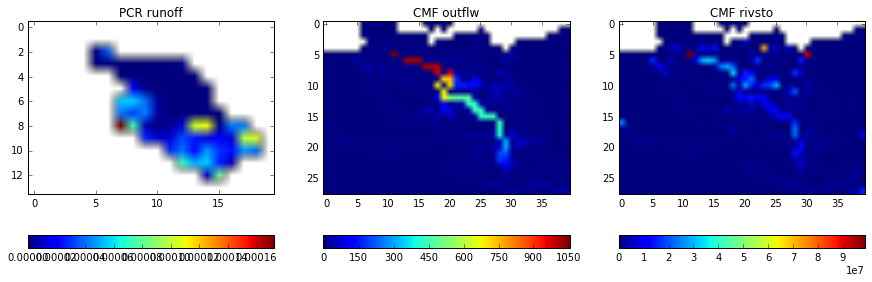

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

# PCR_bmi.update()
# routingModel.update_states()
# routingModel.update() 

runoff = PCR_bmi.get_var('landSurfaceRunoff')
outflw = CMF_bmi.get_var('outflw')
outflw = np.ma.masked_greater(outflw, 1.e19)
rivsto = CMF_bmi.get_var('rivsto_out')
rivsto = np.ma.masked_greater(rivsto, 1.e19)

fig = plt.figure(figsize=(15, 5))
a=fig.add_subplot(1,3,1)
imgplot = plt.imshow(runoff)
a.set_title('PCR runoff')
plt.colorbar(orientation ='horizontal')
a=fig.add_subplot(1,3,2)
imgplot = plt.imshow(outflw)
a.set_title('CMF outflw')
plt.colorbar(orientation='horizontal')
a=fig.add_subplot(1,3,3)
imgplot = plt.imshow(rivsto)
a.set_title('CMF rivsto')
plt.colorbar(orientation='horizontal')

In [17]:
# finalize model
PCR_bmi.finalize()

# finalize model
CMF_bmi.finalize()

INFO: wrapper.finalize(): cd /home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim
2018-03-22 19:58:47,627 bmi.wrapper INFO cd /home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim


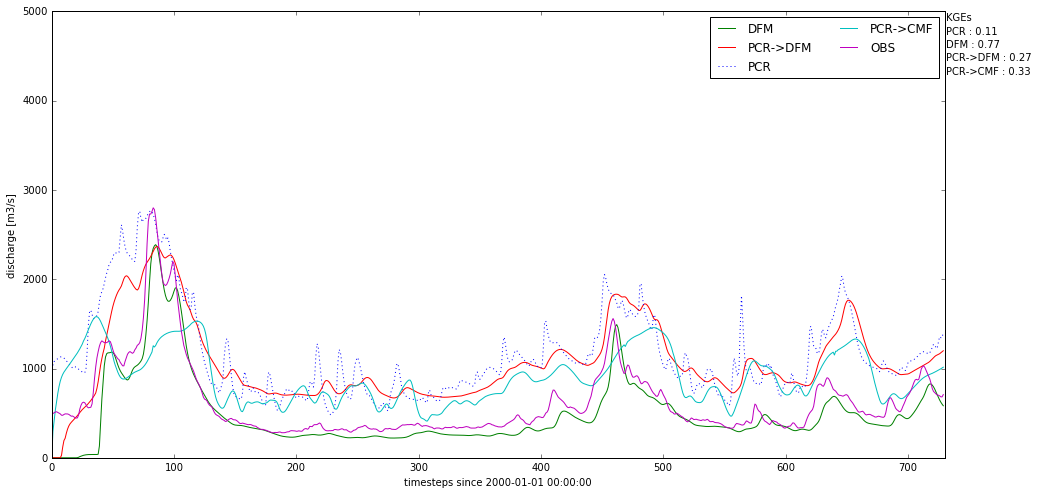

In [18]:
import matplotlib.dates as mdates
from netCDF4 import Dataset

#- laod DFM output file (from 1way coupled PCR->DFM run)
fo_1way = os.path.join(cwd, 'test_Elbe/', 'DFM_Elbe_VU_1way_his.nc')
#- laod DFM output file (from DFM stand alone)
fo_stA = os.path.join(cwd, 'test_Elbe/', 'DFM_Elbe_VU_standAlone_his.nc')
#- load BfG file
vo = os.path.join(cwd, 'test_Elbe/', 'Elbe-W+Q.csv')
#- load PCR file
po = os.path.join(cwd, 'test_Elbe/', 'Qsim_Elbe_Darchau_30min_2000s_industrial_prefactored.dump')

#- extract BfG data for NeuDarchau
vd = np.loadtxt(vo, unpack=True, converters = {0: mdates.strpdate2num('%d-%m-%y')}, delimiter=';', skiprows=4)
qobs_ND = vd[1]

#- estract PCR data
pd = np.loadtxt(po, unpack=True, skiprows=4)
PCR_ND = pd[1]
PCR_ND = PCR_ND[:]

#- extrat CMF data
cd = np.loadtxt(cmf_outFile, unpack=True)

#- extract simulated discharge from nc-file for 1way PCR->DFM
no_1way = Dataset(fo_1way, 'r')
qsim_1way = no_1way.variables['cross_section_discharge'][:]
#- split up to different cross-sectiosn
qsim_upBC_1way = np.absolute(qsim_1way[:,2])
qsim_ND_1way = np.absolute(qsim_1way[:,0])
qsim_downBC_1way = np.absolute(qsim_1way[:,1])

#- extract simulated discharge from nc-file for DFM standalone
no_stA = Dataset(fo_stA, 'r')
qsim_stA = no_stA.variables['cross_section_discharge'][:]
#- split up to different cross-sectiosn
qsim_upBC_stA = np.absolute(qsim_stA[:,2])
qsim_ND_stA = np.absolute(qsim_stA[:,0])
qsim_downBC_stA = np.absolute(qsim_stA[:,1])

#- limit to list with least entries
minLength = min(len(qsim_ND_1way), len(qsim_ND_stA), len(PCR_ND), len(cd))
if len(qobs_ND) > len(cd):
    qobs_ND = qobs_ND[:minLength]
    PCR_ND = PCR_ND[:minLength]
    qsim_ND_1way = qsim_ND_1way[:minLength]
    qsim_ND_stA = qsim_ND_stA[:minLength]
    cd = cd[:minLength]

#- computed KGE at NeuDarchau
KGE_ND_1way = spotpy.objectivefunctions.kge(qobs_ND, qsim_ND_1way)
KGE_ND_1way = np.round(KGE_ND_1way,2)
KGE_ND_stA = spotpy.objectivefunctions.kge(qobs_ND, qsim_ND_stA)
KGE_ND_stA = np.round(KGE_ND_stA,2)
KGE_ND_PCR = spotpy.objectivefunctions.kge(qobs_ND, PCR_ND)
KGE_ND_PCR = np.round(KGE_ND_PCR,2)
KGE_ND_CMF = spotpy.objectivefunctions.kge(qobs_ND, cd)
KGE_ND_CMF = np.round(KGE_ND_CMF,2)

#- plot
plt.figure(figsize=(16,8))
# plt.plot(qsim_downBC, ':', c='r', label = 'Qsim downBC')
plt.plot(qsim_ND_stA, 'g', label = 'DFM')
plt.plot(qsim_ND_1way, 'r', label = 'PCR->DFM')
# plt.plot(qsim_downBC, ':',  c='k', label = 'Qsim downBC')
plt.plot(PCR_ND, ':',label = 'PCR')
plt.plot(cd, c='c', label = 'PCR->CMF')
plt.plot(qobs_ND, 'm', label = 'OBS')
plt.text(minLength+1,4900, 'KGEs') 
plt.text(minLength+1,4750, 'PCR : '+str(KGE_ND_PCR))
plt.text(minLength+1,4600, 'DFM : '+str(KGE_ND_stA))
plt.text(minLength+1,4450, 'PCR->DFM : '+str(KGE_ND_1way))
plt.text(minLength+1,4300, 'PCR->CMF : '+str(KGE_ND_CMF))
plt.legend(ncol=2, loc=1)
plt.xlim(0, minLength)
plt.ylim(0, 5000)
plt.ylabel('discharge [m3/s]')
plt.xlabel('timesteps since '+str(start_date))
plt.savefig(os.path.join(out_dir, 'compareAndvalidate_Qsim_PCR2CMF.png'), dpi=300)

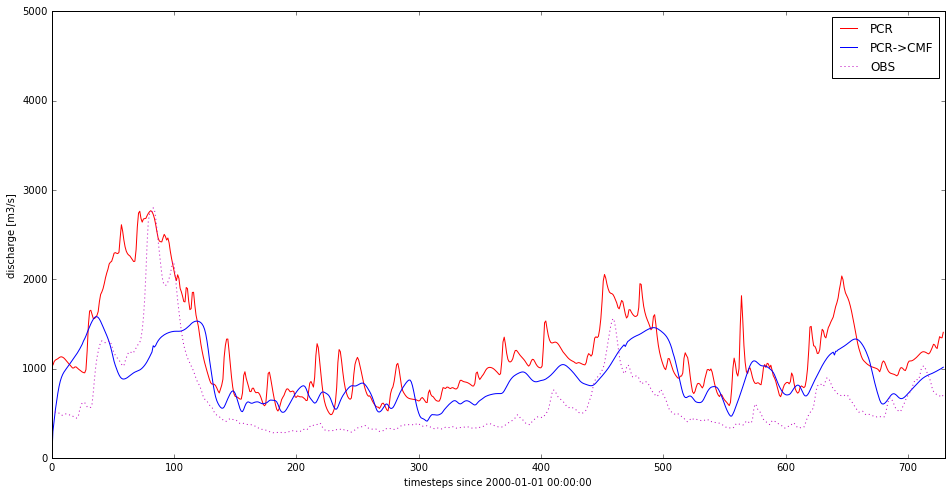

In [19]:
plt.figure(figsize=(16,8))
plt.plot(PCR_ND, 'r',label = 'PCR')
plt.plot(cd, 'b', label = 'PCR->CMF')
plt.plot(qobs_ND, ':', c='m', label = 'OBS')
plt.legend(loc=1)
plt.xlim(0, minLength)
plt.ylim(0, 5000)
plt.ylabel('discharge [m3/s]')
plt.xlabel('timesteps since '+str(start_date))

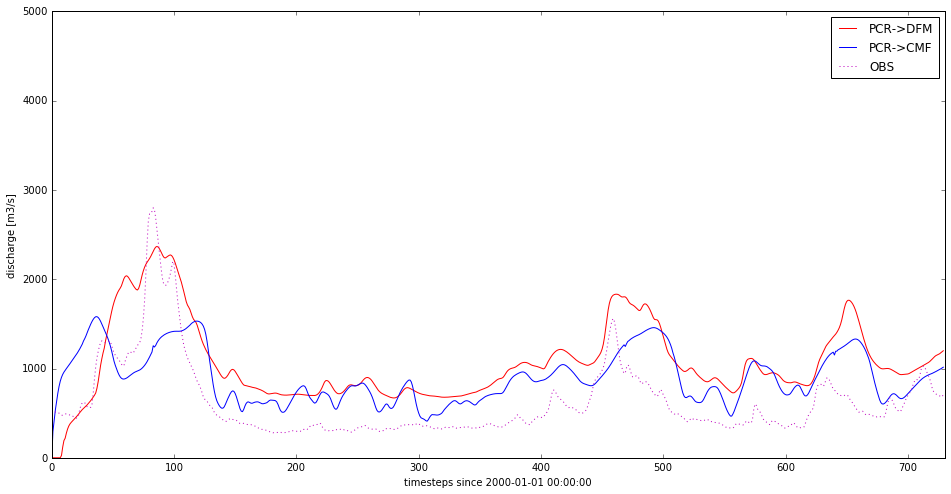

In [20]:
plt.figure(figsize=(16,8))
plt.plot(qsim_ND_1way, 'r',label = 'PCR->DFM')
plt.plot(cd, 'b', label = 'PCR->CMF')
plt.plot(qobs_ND, ':', c='m', label = 'OBS')
plt.legend(loc=1)
plt.xlim(0, minLength)
plt.ylim(0, 5000)
plt.ylabel('discharge [m3/s]')
plt.xlabel('timesteps since '+str(start_date))